# GCM Filters on Irregular Grids

This notebook explains how to use two different filter types with Gcm-filters on irregular grids:
* Filters with **fixed filter length scale**, e.g., a filter that attempts to remove scales smaller than 100km.
* Filters with **fixed coarsening factor**, e.g., a filter that attempts to remove scales smaller than 4 times the local grid scale.

In this example, we are going to use NeverWorld2 data. NeverWorld2 is a **MOM6** simulation in stacked shallow water mode, on a non-global lat-lon grid. The data is stored on NCAR's Casper cluster.

In [1]:
import gcm_filters
import numpy as np
import cupy as cp
import xarray as xr
import matplotlib.pyplot as plt
from dask.diagnostics import ProgressBar

First, we open the 1/8 degree NeverWorld2 data.

In [2]:
run = 26 #1/8 deg
end_time = 31500

st = xr.open_dataset('/glade/p/univ/unyu0004/neerajab/NeverWorld2/run%i/static.nc' % (run), decode_times=False) 

chunks = {'time': 20} 
av = xr.open_dataset('/glade/p/univ/unyu0004/neerajab/NeverWorld2/run%i/averages_000%i.nc' % (run,end_time-500+2), 
                     chunks=chunks, decode_times=False)

These are our horizontal dimensions:

In [3]:
Nx = np.size(st.xh)
Ny = np.size(st.yh)
print('Nx = %i, Ny = %i' %(Nx,Ny))

Nx = 480, Ny = 1120


## Filter with fixed filter length scale

The following are the grid types that we have so far implemented in GCM-filters:

In [4]:
list(gcm_filters.GridType)

[<GridType.REGULAR: 1>,
 <GridType.REGULAR_WITH_LAND: 2>,
 <GridType.IRREGULAR_WITH_LAND: 3>,
 <GridType.TRIPOLAR_REGULAR_WITH_LAND: 4>,
 <GridType.TRIPOLAR_POP_WITH_LAND: 5>]

To filter with fixed filter length scale, we will use the grid type: `IRREGULAR_WITH_LAND`, and its associated Laplacian. The Laplacian needs the following grid variables:

In [5]:
gcm_filters.required_grid_vars(gcm_filters.GridType.IRREGULAR_WITH_LAND)

['wet_mask', 'dxw', 'dyw', 'dxs', 'dys', 'area']

In our example, we will filter **tracer fields**, i.e., fields that are defined at T-points (e.g., `h`, `KE`). 

(`IRREGULAR_WITH_LAND` could also be used to filter U-fields or V-fields, but we would have to create the filter with different arguments for `wet_mask`, `dxw`, `dyw`, `dxs`, `dys`, `area`.)

`wet_mask` and `area` we have directly available from our model output:

In [6]:
wet_mask = st.wet
area = st.area_t

For the remaining grid variables, recall the following conventions:

* `dxw` = x-spacing centered at western cell edge
* `dyw` = y-spacing centered at western cell edge
* `dxs` = x-spacing centered at southern cell edge
* `dys` = y-spacing centered at southern cell edge

We get these grid variables from our model output as follows:

In [7]:
dxw = xr.DataArray(data=st.dxCu.isel(xq=slice(0,Nx)),coords={'yh':av.yh,'xh':av.xh}, dims=('yh','xh'))
dyw = xr.DataArray(data=st.dyCu.isel(xq=slice(0,Nx)),coords={'yh':av.yh,'xh':av.xh}, dims=('yh','xh'))
dxs = xr.DataArray(data=st.dxCv.isel(yq=slice(0,Ny)),coords={'yh':av.yh,'xh':av.xh}, dims=('yh','xh'))
dys = xr.DataArray(data=st.dyCv.isel(yq=slice(0,Ny)),coords={'yh':av.yh,'xh':av.xh}, dims=('yh','xh'))

Text(0.5, 1.0, 'area')

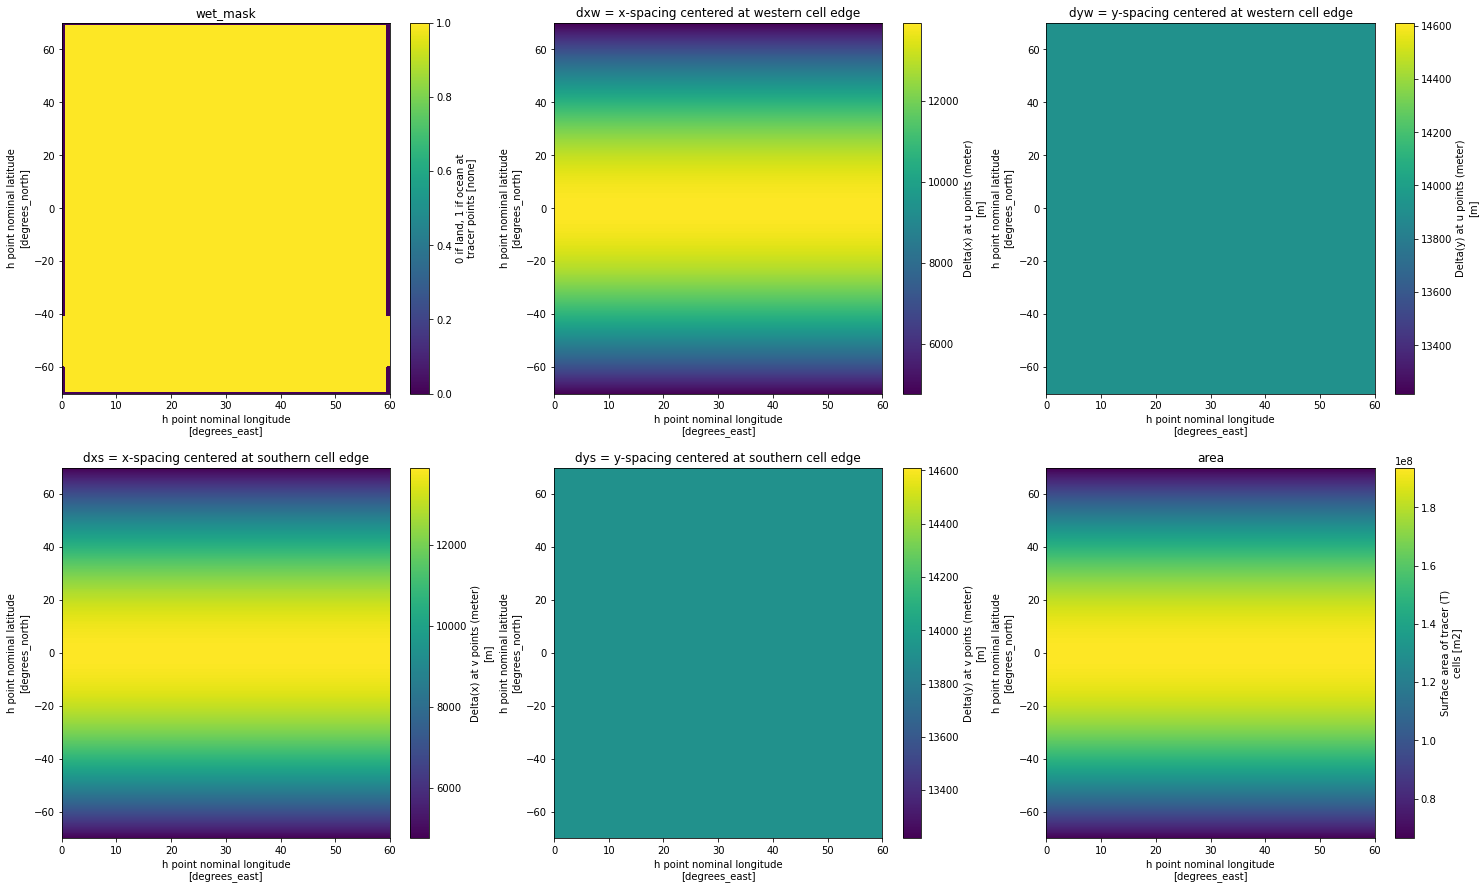

In [8]:
fig,axs = plt.subplots(2,3,figsize=(25,15))
wet_mask.plot(ax=axs[0,0])
axs[0,0].set_title('wet_mask')
dxw.plot(ax=axs[0,1])
axs[0,1].set_title('dxw = x-spacing centered at western cell edge')
dyw.plot(ax=axs[0,2])
axs[0,2].set_title('dyw = y-spacing centered at western cell edge')
dxs.plot(ax=axs[1,0])
axs[1,0].set_title('dxs = x-spacing centered at southern cell edge')
dys.plot(ax=axs[1,1])
axs[1,1].set_title('dys = y-spacing centered at southern cell edge')
area.plot(ax=axs[1,2])
axs[1,2].set_title('area')

While the y-spacing is constant over our domain, the x-spacing varies with latitude:

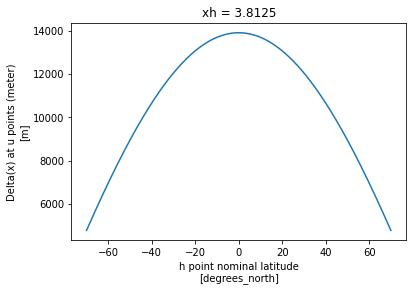

In [9]:
dxw.isel(xh=30).plot()

The filter needs to know what the minimum grid spacing is in our model.

In [10]:
dx_min = min(dxw.min(),dyw.min(),dxs.min(),dys.min())
dx_min = dx_min.values
dx_min

array(4759.08629892)

In our example, we choose the (fixed) filter scale to be 100km. (Note that we need: `filter_scale` >= `dx_min`.)

In [11]:
filter_scale = 100000

### Filter on CPU using dask

We are now ready to create our filter. As a start, we choose `n_steps` = 30.

In [12]:
filter = gcm_filters.Filter(
    filter_scale=filter_scale,
    dx_min=dx_min,
    filter_shape=gcm_filters.FilterShape.GAUSSIAN,
    n_steps=30,
    grid_type=gcm_filters.GridType.IRREGULAR_WITH_LAND,
    grid_vars={'wet_mask': wet_mask, 'dxw': dxw, 'dyw': dyw, 'dxs': dxs, 'dys': dys, 'area': area}
)
filter

Filter(filter_scale=100000, dx_min=array(4759.08629892), filter_shape=<FilterShape.GAUSSIAN: 1>, transition_width=3.141592653589793, ndim=2, n_steps=30, grid_type=<GridType.IRREGULAR_WITH_LAND: 3>)



We will apply the filter to `av.KE`, which is a Dask array:

In [13]:
av.KE

<xarray.DataArray 'KE' (time: 100, zl: 15, yh: 1120, xh: 480)>
dask.array<open_dataset-dd984f45942772e19f542bb66c654facKE, shape=(100, 15, 1120, 480), dtype=float32, chunksize=(20, 15, 1120, 480), chunktype=numpy.ndarray>
Coordinates:
  * yh       (yh) float64 -69.94 -69.81 -69.69 -69.56 ... 69.69 69.81 69.94
  * zl       (zl) float64 1.023e+03 1.023e+03 1.023e+03 ... 1.028e+03 1.028e+03
  * time     (time) float64 3.1e+04 3.101e+04 3.101e+04 ... 3.149e+04 3.15e+04
  * xh       (xh) float64 0.0625 0.1875 0.3125 0.4375 ... 59.69 59.81 59.94
Attributes:
    long_name:      Layer kinetic energy per unit mass
    units:          m2 s-2
    cell_methods:   area:mean zl:mean yh:mean xh:mean time: mean
    cell_measures:  area: area_t
    time_avg_info:  average_T1,average_T2,average_DT

In [14]:
KE_filtered = filter.apply(av.KE, dims=['yh', 'xh'])

Since we used a Dask array as an input, the filter operates lazily. The actual execution (in parallel) will happen next, when we plot the filtered field.

[########################################] | 100% Completed |  3min 44.6s
[########################################] | 100% Completed |  3min 42.3s


Text(0.5, 1.0, 'Difference')

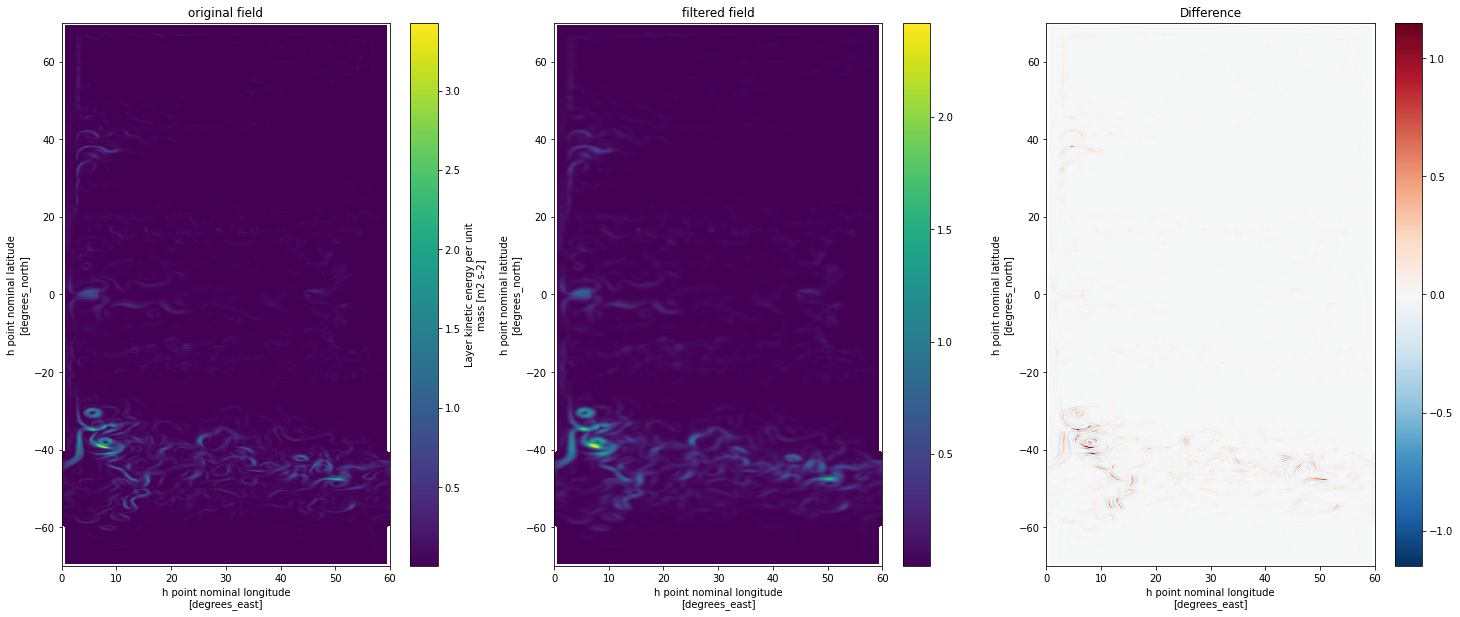

In [15]:
time = -1
layer = 0

fig,axs = plt.subplots(1,3,figsize=(25,10))
av.KE.isel(time=time,zl=layer).plot(ax=axs[0])
axs[0].set_title('original field')
with ProgressBar():
    KE_filtered.isel(time=time,zl=layer).plot(ax=axs[1])
axs[1].set_title('filtered field')
with ProgressBar():
    (av.KE - KE_filtered).isel(time=time,zl=layer).plot(ax=axs[2])
axs[2].set_title('Difference')

Since this is a filter with **fixed filter scale** (= 100km), a smoother structure is most visible at the high latitudes, where the grid spacing is the smallest.

We will now move to a GPU - we will see that this is much faster.

### Filter on GPU using dask

First, we create Dask arrays with cupy blocks.

In [16]:
wet_mask = wet_mask.chunk({'yh': Ny,'xh': Nx}) # 1 chunk
wet_mask.data = wet_mask.data.map_blocks(cp.asarray)
wet_mask

<xarray.DataArray 'wet' (yh: 1120, xh: 480)>
dask.array<asarray, shape=(1120, 480), dtype=float64, chunksize=(1120, 480), chunktype=cupy.ndarray>
Coordinates:
  * xh       (xh) float64 0.0625 0.1875 0.3125 0.4375 ... 59.69 59.81 59.94
  * yh       (yh) float64 -69.94 -69.81 -69.69 -69.56 ... 69.69 69.81 69.94
Attributes:
    long_name:      0 if land, 1 if ocean at tracer points
    units:          none
    cell_methods:   time: point
    cell_measures:  area: area_t

In [17]:
dxw = dxw.chunk({'yh': Ny,'xh': Nx}) # 1 chunk
dxw.data = dxw.data.map_blocks(cp.asarray)

dyw = dyw.chunk({'yh': Ny,'xh': Nx}) # 1 chunk
dyw.data = dyw.data.map_blocks(cp.asarray)

dxs = dxs.chunk({'yh': Ny,'xh': Nx}) # 1 chunk
dxs.data = dxs.data.map_blocks(cp.asarray)

dys = dys.chunk({'yh': Ny,'xh': Nx}) # 1 chunk
dys.data = dys.data.map_blocks(cp.asarray)

area = area.chunk({'yh': Ny,'xh': Nx}) # 1 chunk
area.data = area.data.map_blocks(cp.asarray)

In [18]:
KE = av.KE.copy()
KE.data = KE.data.map_blocks(cp.asarray)
KE

<xarray.DataArray 'KE' (time: 100, zl: 15, yh: 1120, xh: 480)>
dask.array<asarray, shape=(100, 15, 1120, 480), dtype=float32, chunksize=(20, 15, 1120, 480), chunktype=cupy.ndarray>
Coordinates:
  * yh       (yh) float64 -69.94 -69.81 -69.69 -69.56 ... 69.69 69.81 69.94
  * zl       (zl) float64 1.023e+03 1.023e+03 1.023e+03 ... 1.028e+03 1.028e+03
  * time     (time) float64 3.1e+04 3.101e+04 3.101e+04 ... 3.149e+04 3.15e+04
  * xh       (xh) float64 0.0625 0.1875 0.3125 0.4375 ... 59.69 59.81 59.94
Attributes:
    long_name:      Layer kinetic energy per unit mass
    units:          m2 s-2
    cell_methods:   area:mean zl:mean yh:mean xh:mean time: mean
    cell_measures:  area: area_t
    time_avg_info:  average_T1,average_T2,average_DT

Because the GPU is much faster, we can easily increase `n_steps` to 50. This is a more accurate approximation of our target filter.

In [19]:
filter = gcm_filters.Filter(
    filter_scale=filter_scale,
    dx_min=dx_min,
    filter_shape=gcm_filters.FilterShape.GAUSSIAN,
    n_steps=50,
    grid_type=gcm_filters.GridType.IRREGULAR_WITH_LAND,
    grid_vars={'wet_mask': wet_mask, 'dxw': dxw, 'dyw': dyw, 'dxs': dxs, 'dys': dys, 'area': area}
)
filter

Filter(filter_scale=100000, dx_min=array(4759.08629892), filter_shape=<FilterShape.GAUSSIAN: 1>, transition_width=3.141592653589793, ndim=2, n_steps=50, grid_type=<GridType.IRREGULAR_WITH_LAND: 3>)

Filter lazily on GPU:

In [20]:
KE_filtered = filter.apply(KE, dims=['yh', 'xh'])

Note that the execution is much faster than before on the CPU:

[########################################] | 100% Completed |  6.1s
[########################################] | 100% Completed |  1.7s


Text(0.5, 1.0, 'Difference')

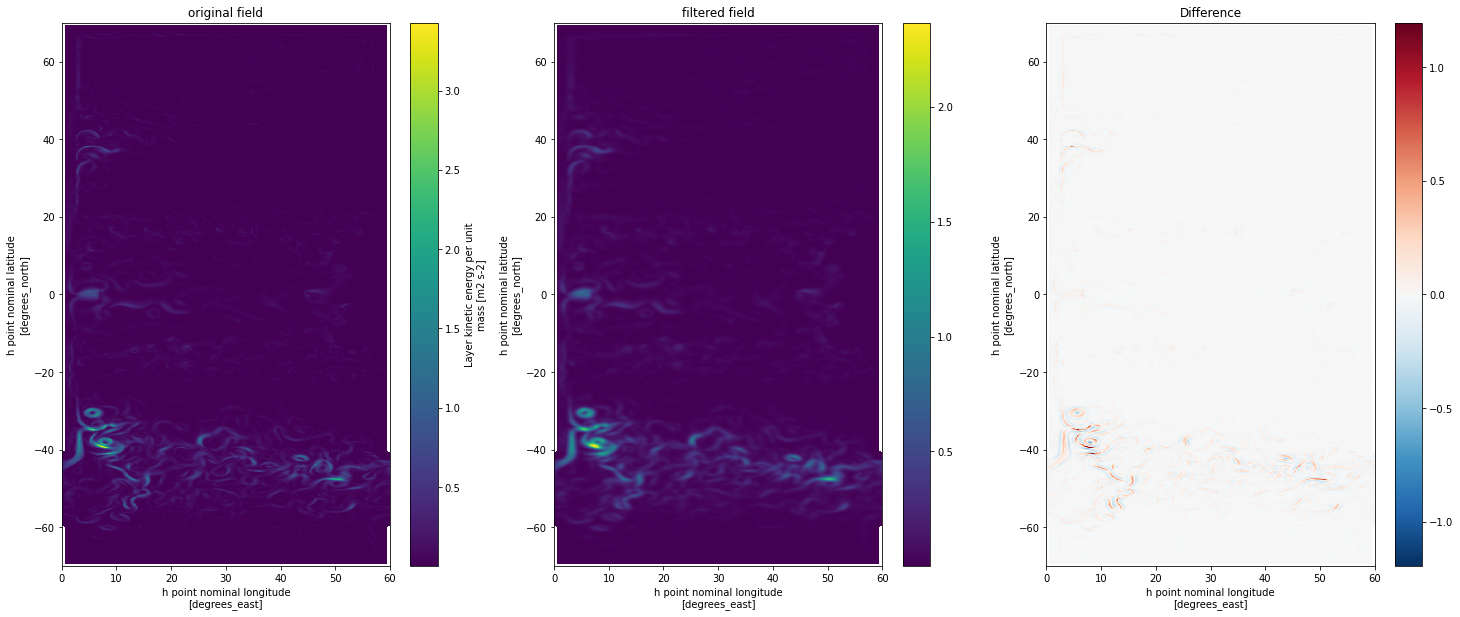

In [21]:
time = -1
layer = 0

fig,axs = plt.subplots(1,3,figsize=(25,10))
KE.isel(time=time,zl=layer).plot(ax=axs[0])
axs[0].set_title('original field')
with ProgressBar():
    KE_filtered.isel(time=time,zl=layer).plot(ax=axs[1])
axs[1].set_title('filtered field')
with ProgressBar():
    (KE - KE_filtered).isel(time=time,zl=layer).plot(ax=axs[2])
axs[2].set_title('Difference')

## Filter with fixed coarsening factor

To filter with fixed coarsening factor equal to 4, we perform the following steps:
* **Before** filtering, **multiply the field by the local cell area**.
* Apply filter with `dx_min=1` and `filter_scale=4`, pretending the grid was uniform.
* **After** filtering, **divide** filtered field **by local cell area**.

The actual filtering operation in the second step uses a Laplacian on a regular grid. This Laplacian requires the following arguments:

In [22]:
gcm_filters.required_grid_vars(gcm_filters.GridType.REGULAR_WITH_LAND)

['wet_mask']

We will skip the CPU, and move directly to a GPU to apply our filter. (But everything works similarly on a CPU.) Conveniently, `wet_mask` and `KE` are already Dask arrays with cupy blocks (see above). First, we create our filter.

In [23]:
filter2 = gcm_filters.Filter(
    filter_scale=4,
    dx_min=1,
    filter_shape=gcm_filters.FilterShape.GAUSSIAN,
    n_steps=8,
    grid_type=gcm_filters.GridType.REGULAR_WITH_LAND,
    grid_vars={'wet_mask': wet_mask}
)
filter2

Filter(filter_scale=4, dx_min=1, filter_shape=<FilterShape.GAUSSIAN: 1>, transition_width=3.141592653589793, ndim=2, n_steps=8, grid_type=<GridType.REGULAR_WITH_LAND: 2>)

Then, we filter `KE` * `area` lazily on a GPU.

In [24]:
KE_filtered_2 = filter2.apply(KE * area, dims=['yh', 'xh'])

Next, we divide the filtered field by `area`.

In [25]:
KE_filtered_2 = KE_filtered_2/area

Finally, we plot.

[########################################] | 100% Completed |  1.7s
[########################################] | 100% Completed |  1.8s


Text(0.5, 1.0, 'Difference')

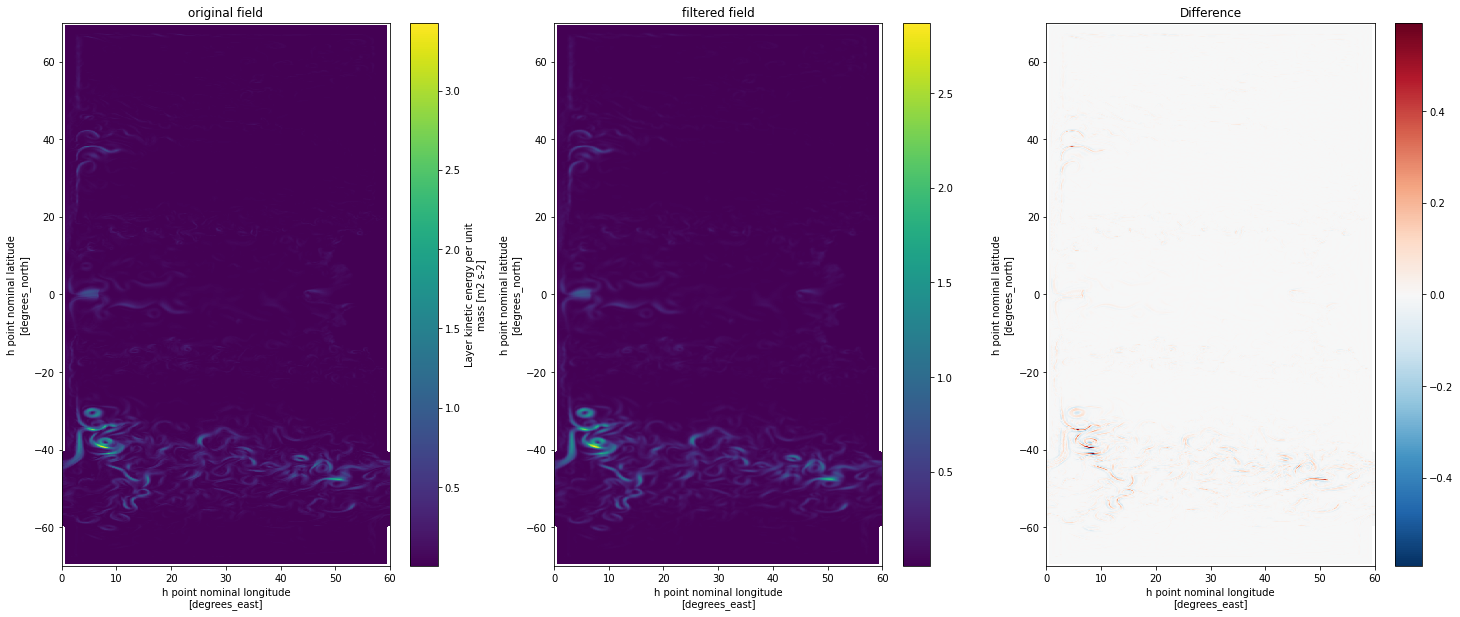

In [26]:
time = -1
layer = 0

fig,axs = plt.subplots(1,3,figsize=(25,10))
KE.isel(time=time,zl=layer).plot(ax=axs[0])
axs[0].set_title('original field')
with ProgressBar():
    KE_filtered_2.isel(time=time,zl=layer).plot(ax=axs[1])
axs[1].set_title('filtered field')
with ProgressBar():
    (KE - KE_filtered_2).isel(time=time,zl=layer).plot(ax=axs[2])
axs[2].set_title('Difference')

The following is the same plot, but zoomed into a subregion of the ACC:

[########################################] | 100% Completed |  1.0s
[########################################] | 100% Completed |  1.0s


Text(0.5, 1.0, 'Difference')

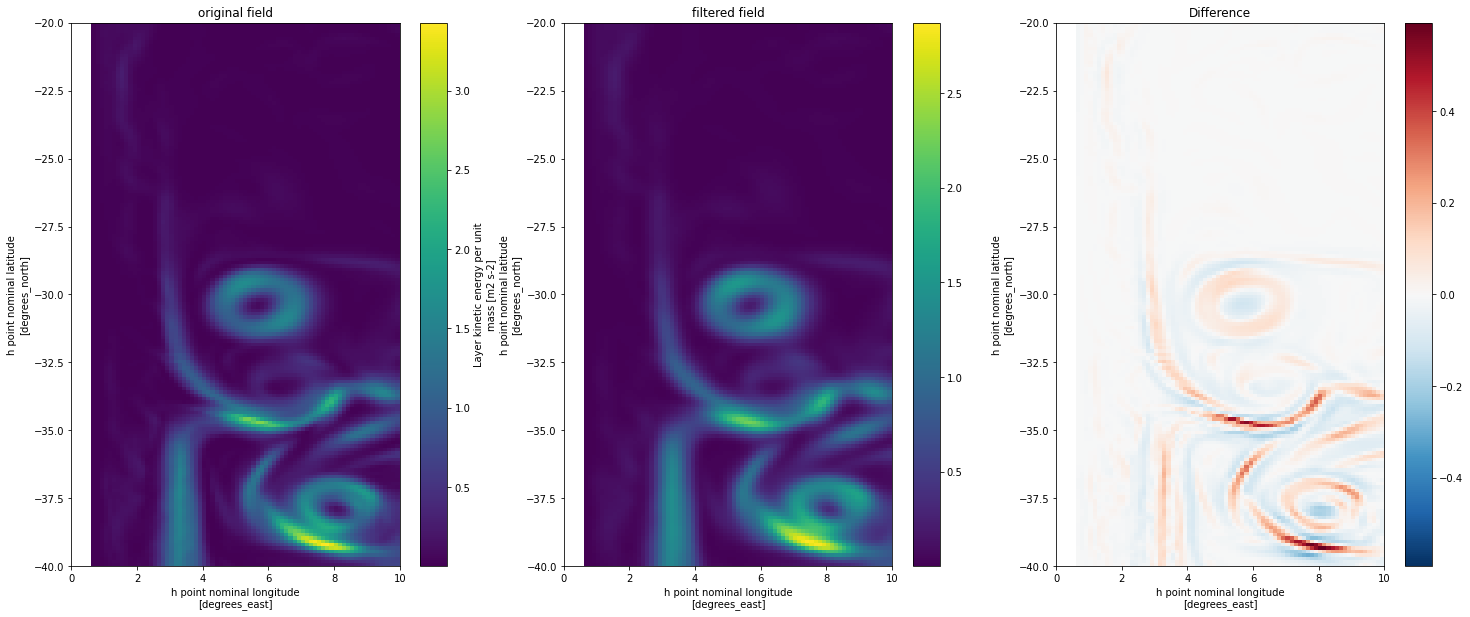

In [27]:
time = -1
layer = 0
xslice = slice(0,10)
yslice = slice(-40,-20)

fig,axs = plt.subplots(1,3,figsize=(25,10))
KE.isel(time=time,zl=layer).sel(xh=xslice,yh=yslice).plot(ax=axs[0])
axs[0].set_title('original field')
with ProgressBar():
    KE_filtered_2.isel(time=time,zl=layer).sel(xh=xslice,yh=yslice).plot(ax=axs[1])
axs[1].set_title('filtered field')
with ProgressBar():
    (KE - KE_filtered_2).isel(time=time,zl=layer).sel(xh=xslice,yh=yslice).plot(ax=axs[2])
axs[2].set_title('Difference')